# Instrucciones Parte Computacional
## Tarea 3 ICS 3153 - Optimización Avanzada

En la pregunta 3.b. de su tarea se le pide plantear un método numérico para resolver el problema SVM.

$$
\min _ { x \in \mathbb { R } ^ { d } } \left[ F ( x ) = \sum _ { i = 1 } ^ { n } \operatorname { máx } \left\{ 0,1 - y _ { i } \left\langle w _ { i } , x \right\rangle \right\} + \frac { \alpha } { 2 } \| x \| _ { 2 } ^ { 2 } \right] \quad \text { (SVM) }
$$

Para tener un benchmark, se le propone comparar el gap de cada paso de su método con la solución del solver LinearSVC de Sklearn. 

In [21]:
from sklearn.svm import LinearSVC
from sklearn.datasets import make_classification
import numpy as np

## Datasets
A continuación se le provee de un dataset sobre al cual debe trabajar. El conjunto datos es de la forma  $$
\left\{ \left( w _ { i } , y _ { i } \right) \right\} _ { i = 1 , \ldots , 100 } \subseteq \mathbb { R } ^ { 4 } \times \{ - 1 , + 1 \}
$$

### OJO: la semilla (seed) no debe cambiarla de 0, pues no queremos generar distintos datasets cada vez

In [22]:
seed=0

In [23]:
W, y = make_classification(n_features=4, random_state=seed)
y = 2*(y-0.5)

In [24]:
print("Dimensiones de las features: ",W.shape)
print("Dimensiones de los labels: ",y.shape)

Dimensiones de las features:  (100, 4)
Dimensiones de los labels:  (100,)


Los datos ya se encuentran preprocesados por lo que no debe preocuparse de eso.

In [25]:
W[0:4], y[0:4]

(array([[-0.07156026,  0.2295539 ,  0.21654345,  0.06527398],
        [-0.4032571 ,  2.00618406,  2.02751248,  0.85089194],
        [-1.13058206, -0.02029593, -0.71023363, -1.44099108],
        [ 0.18332468, -0.77461035, -0.76605469, -0.29366863]]),
 array([ 1.,  1., -1., -1.]))

## LinearSVC

A continuación corremos el solver de SKlearn. Aquí el parámetro C correponde a $\frac{1}{\alpha}$ en la formulación (SVM) del enunciado 

In [26]:
alpha = 1. 

In [27]:
svm = LinearSVC(C= 1/alpha, random_state=seed,
                tol=1e-5,max_iter=1000,
                loss = 'hinge', dual = True)
svm.fit(W,y)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='hinge', max_iter=1000, multi_class='ovr',
     penalty='l2', random_state=0, tol=1e-05, verbose=0)

## Extracción del $x^*$ entregado por el solver

Debe comparar las soluciones de método son el óptimo encontrado por el solver LinearSVC

In [28]:
x_opt = svm.coef_
x_opt

array([[0.13065512, 0.78724747, 0.97122779, 0.69859935]])

# Función de pérdida

La función de pérdida del enunciado a minimizar en (SVM) es la siguiente 

In [29]:
def F(W,y,alpha, x):
    suma = 0
    for i in range(len(y)):
        suma += max(0, 1 - y[i] * float(np.dot(W[i],x.T)))
    suma += (alpha/2)*float(np.dot(x,x.T))
    return suma

## $F(x^*)$

El valor de la función de pérdida en en óptimo está dada por:

In [30]:
F(W,y,alpha,x_opt)

30.139424714873634

Compare el gap de optimalidad de su método con  $F(x^*)$. También debe comparar el score (% de accuracy) de su clasificador lineal contra el del solver

In [31]:
svm.score(W,y)

0.94

In [32]:
# Ahora comenzaremos a aplicar nuestro método
# El método que utilizaremos es el método del "subgradiente" el cual se encuentra explicado en el informe
# Lo primero que haremos es programar un método que calcule el subgradiente

In [33]:
def calcular_subgradiente(x):
    #Como se eligio alpha = 1
    subg=x
    for i in range(len(y)):
        t=y[i] * float(np.dot(W[i],x.T))
        if t<1:
            subg=subg-y[i]*W[i]
        if t==1:
            subg=subg-((y[i]*W[i])/2)
    return subg

In [34]:
# También calcularemos la presición de nuestro método

def calcular_precision(x):
    contador=0
    for i in range(100):
        r=(y[i]-np.sign(float(np.dot(W[i],x.T))))
        if r==0:
            contador=contador+1
    return contador/100

In [35]:
# Ahora implementaremos el metodo del subgradiente con backtring con un número de iteraciones arbitrario

def subgradiente_backtracking(n):
    lista=[]
    lista_2=[]
    eta = 1
    x = np.array([0,0,0,0])
    lista.append(x)
    for i in range(n):
        v=x
        x=x-eta*calcular_subgradiente(x)
        F2=F(W,y,alpha,x)
        h=x-v
        F1=F(W,y,alpha,v) + float(np.dot(calcular_subgradiente(v),h.T)) + (1/(2*eta))*float(np.dot(h,h.T))
        z=(F2<=F1)
        if z==True:
            lista.append(x)
            lista_2.append(calcular_precision(x))
        else:
            eta=eta/2
            x=v
            lista.append(x)
            lista_2.append(calcular_precision(x))
    lista_final=[]
    lista_final.append(lista)
    lista_final.append(lista_2)
    lista_final.append(lista[len(lista)-1])
    return lista_final  

In [36]:
# Ahora correremos nuestro método con:

n=100

x_alg=(subgradiente_backtracking(n))[2]

F(W,y,alpha,x_alg)

28.898100317112004

In [37]:
# Ahora también calcularemos cuantos puntos clasifico bien el algoritmo

p=(subgradiente_backtracking(n))[1]

prec=p[len(p)-1]

print(prec)

0.88


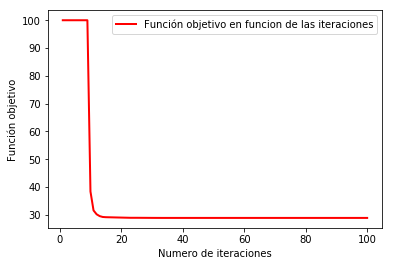

In [44]:
# Ahora lo que haremos será graficar como varían la función objetivo de nuestro algoritmo en función de las iteraciones


import matplotlib.pyplot as plt

u=[]

for j in range(n):
    u.append(j+1)

resultado=(subgradiente_backtracking(n))[0]

eje_y=[]

for k in range(n):
    eje_y.append(F(W,y,alpha,resultado[k]))

plt.plot(u,eje_y,color="r", linewidth=2, label='Función objetivo en funcion de las iteraciones')

plt.xlabel('Numero de iteraciones')
plt.ylabel('Función objetivo')
plt.legend(loc='best')
plt.show()

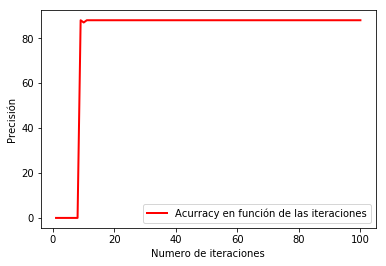

In [45]:
# Ahora también graficaremos como va variando la precisión del algoritmo en función de las iteraciones

u=[]

for j in range(n):
    u.append(j+1)

resultado_2=(subgradiente_backtracking(n))[1]

eje_y=[]

for k in range(n):
    eje_y.append(resultado_2[k]*100)

plt.plot(u,eje_y,color="r", linewidth=2, label='Acurracy en función de las iteraciones')

plt.xlabel('Numero de iteraciones')
plt.ylabel('Precisión')
plt.legend(loc='best')
plt.show()